In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import h5py
from numpy.core.function_base import linspace
import random
import time
from random import sample
from sklearn.metrics import accuracy_score
from keras import backend as K 
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

In [ ]:
#task-1 intra


In [ ]:
state = lambda x: '0' if x<18 else ('1' if x<24 else  ('2' if x<29 else  '3'  ))

In [ ]:
path='drive/MyDrive/Data_Ass3/Intra/train/'

In [ ]:
#downsampling to 50Hz 
tempx=np.zeros([1,248])
tempy=np.zeros([1,1])
for i in os.listdir(path):
   y=state(len(i))
   with h5py.File(path+i,'r') as f:
      dataset_name = get_dataset_name(path+i)
      matrix = f.get(dataset_name)[()]
      for j in range(0,matrix.shape[1],50):
        x=matrix[:,j]
        tempx=np.vstack((tempx,x))
        tempy=np.vstack((tempy,y))

    


In [ ]:
#normalising and converting 1d array to 16*16 2d array
trainx=np.zeros([tempx.shape[0],16,16])  
for j in range(tempx.shape[0]):
  x=tempx[j,:]
  x = (x-x.min())/(x.max()-x.min())
  x=np.insert(x,0,[0,0])
  x=np.insert(x,14,[0,0])
  x=np.insert(x,len(x),[0,0])
  x=np.insert(x,len(x)-14,[0,0])
  x=x.reshape(1,16,16)
  trainx[j,:,:]=x
trainy=tempy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
safex=trainx
safey=trainy

trainx=trainx[1:,:,:]
trainy=trainy[1:,:]

In [ ]:
print(trainx.shape,trainy.shape)

(22816, 16, 16) (22816, 1)


In [ ]:
#shuffling the samples
shuf = random.sample(range(trainx.shape[0]),trainx.shape[0])
trainxshuf = np.zeros([trainx.shape[0],16,16])
trainyshuf = np.zeros([trainy.shape[0],1])
j=0
for i in range(len(shuf)):    
    trainxshuf[j,:,:]=trainx[i,:,:]
    trainyshuf[j,:]=trainy[i,:]
    j+=1

In [ ]:
print(trainxshuf.shape,trainyshuf.shape)

(22816, 16, 16) (22816, 1)


In [ ]:
patht='drive/MyDrive/Data_Ass3/Intra/test/'

In [ ]:
#downsample the test set to 50Hz
tempx=np.zeros([1,248])
tempy=np.zeros([1,1])
for i in os.listdir(patht):
   y=state(len(i))
   with h5py.File(patht+i,'r') as f:
      dataset_name = get_dataset_name(patht+i)
      matrix = f.get(dataset_name)[()]
      for j in range(0,matrix.shape[1],50):
        x=matrix[:,j]
        tempx=np.vstack((tempx,x))
        tempy=np.vstack((tempy,y))

    


In [ ]:
#normalisation
testx=np.zeros([tempx.shape[0],16,16])  
for j in range(tempx.shape[0]):
  x=tempx[j,:]
  x = (x-x.min())/(x.max()-x.min())
  x=np.insert(x,0,[0,0])
  x=np.insert(x,14,[0,0])
  x=np.insert(x,len(x),[0,0])
  x=np.insert(x,len(x)-14,[0,0])
  x=x.reshape(1,16,16)
  testx[j,:,:]=x
testy=tempy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
safetx=testx
safety=testy

testx=testx[1:,:,:]
testy=testy[1:,:]

In [ ]:
print(testx.shape,testy.shape)

(5704, 16, 16) (5704, 1)


In [ ]:
#CNN Model
def model_init():
  init_input=keras.Input(shape=(16,16,1),name="image")
  x1=layers.Conv2D(4,(4,4),strides=2)(init_input)
  x1=layers.MaxPooling2D((2,2))(x1)
  x3=layers.Conv2D(16,(3,3),strides=2,padding="same")(x1)
  x3=layers.BatchNormalization()(x3)
  x4=layers.Flatten()(x3)
  x4=layers.Activation("relu")(x4)
  x5=layers.Dense(64,"relu")(x4)
  x6=layers.Dense(16,"relu")(x5)
  x9=layers.Dense(4)(x6)
  pred=layers.Activation("softmax")(x9)
  model=keras.Model(inputs=init_input,outputs=pred)
  model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
  return model

In [ ]:
model=model_init()
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 16, 16, 1)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 4)           68        
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 3, 3, 4)          0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 2, 2, 16)          592       
                                                                 
 batch_normalization_22 (Bat  (None, 2, 2, 16)         64        
 chNormalization)                                                
                                                                 
 flatten_22 (Flatten)        (None, 64)                0  

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
#hyperparameter tuning:batch size
with HiddenPrints():  
  bs1=model.fit(trainxshuf,trainyshuf,batch_size=8,validation_split=0.2,epochs=5)
  model=model_init()
  bs2=model.fit(trainxshuf,trainyshuf,batch_size=16,validation_split=0.2,epochs=5)
  model=model_init()
  bs3=model.fit(trainxshuf,trainyshuf,batch_size=32,validation_split=0.2,epochs=5)
  model=model_init()
  bs4=model.fit(trainxshuf,trainyshuf,batch_size=64,validation_split=0.2,epochs=5)


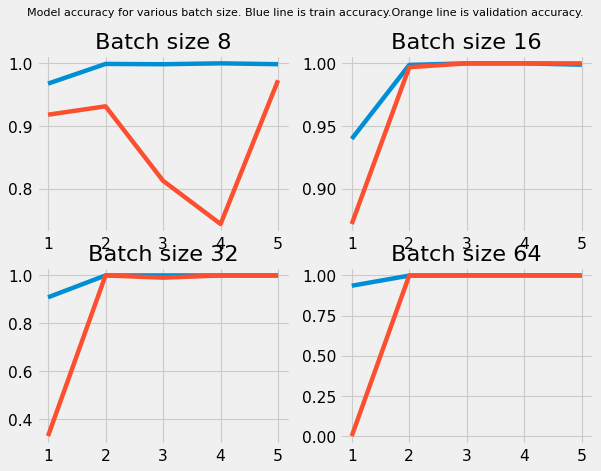

In [ ]:
y=[1,2,3,4,5]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.gca().set_title('Batch size 8')
plt.plot(y,bs1.history['accuracy'])
plt.plot(y,bs1.history['val_accuracy'])
plt.subplot(2, 2, 2)
plt.gca().set_title('Batch size 16')
plt.plot(y,bs2.history['accuracy'])
plt.plot(y,bs2.history['val_accuracy'])
plt.subplot(2, 2, 3)
plt.plot(y,bs3.history['accuracy'])
plt.plot(y,bs3.history['val_accuracy'])
plt.gca().set_title('Batch size 32')
plt.subplot(2, 2, 4)
plt.plot(y,bs4.history['accuracy'])
plt.plot(y,bs4.history['val_accuracy'])
plt.gca().set_title('Batch size 64')
fig.suptitle('Model accuracy for various batch size. Blue line is train accuracy.Orange line is validation accuracy.', fontsize=10)
plt.show()

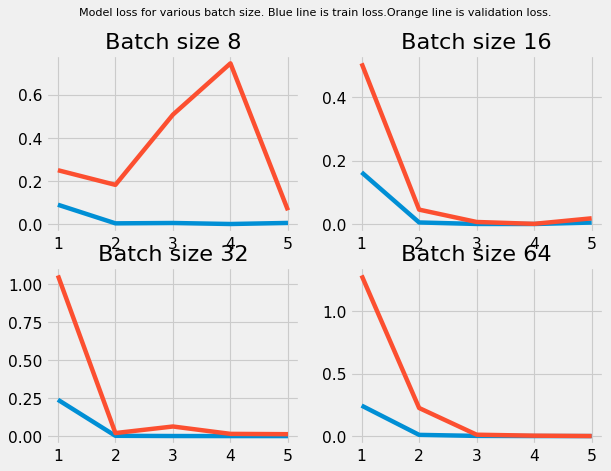

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.gca().set_title('Batch size 8')
plt.plot(y,bs1.history['loss'])
plt.plot(y,bs1.history['val_loss'])
plt.subplot(2, 2, 2)
plt.gca().set_title('Batch size 16')
plt.plot(y,bs2.history['loss'])
plt.plot(y,bs2.history['val_loss'])
plt.subplot(2, 2, 3)
plt.plot(y,bs3.history['loss'])
plt.plot(y,bs3.history['val_loss'])
plt.gca().set_title('Batch size 32')
plt.subplot(2, 2, 4)
plt.plot(y,bs4.history['loss'])
plt.plot(y,bs4.history['val_loss'])
plt.gca().set_title('Batch size 64')
fig.suptitle('Model loss for various batch size. Blue line is train loss.Orange line is validation loss.', fontsize=10)
plt.show()

In [ ]:
#taking batch size=64 and run a final model for intra task
model=model_init()
history=model.fit(trainxshuf,trainyshuf,batch_size=32,validation_split=0.2,epochs=10)

Epoch 1/10
571/571 [==============================] - 3s 4ms/step - loss: 0.2305 - accuracy: 0.9092 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 2/10
571/571 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 1.5385e-04 - val_accuracy: 1.0000
Epoch 3/10
571/571 [==============================] - 2s 4ms/step - loss: 3.9236e-04 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 0.9998
Epoch 4/10
571/571 [==============================] - 2s 4ms/step - loss: 1.5176e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/10
571/571 [==============================] - 2s 4ms/step - loss: 5.1885e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 6/10
571/571 [==============================] - 2s 4ms/step - loss: 2.5648e-05 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9998
Epoch 7/10
571/571 [==============================] - 2s 4ms/step - loss: 2.5581e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


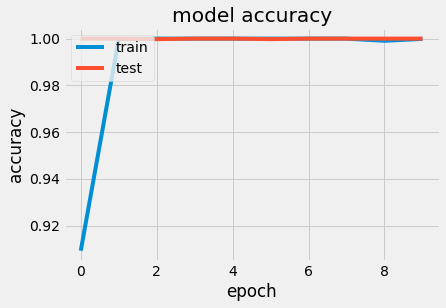

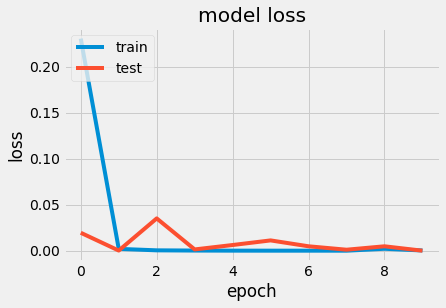

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred=model.predict(testx)

In [ ]:
predic=np.zeros([5704,1])
j=0
for i in pred:
  predic[j,:]=str(np.argmax(i))
  j+=1
predic=np.char.mod('%d', predic)

In [ ]:
#the model is able to predict well
accuracy_score(testy,predic)

1.0

In [ ]:
#task 2 - cross 
path2='drive/MyDrive/Data_Ass3/Cross/train/'
#downsample to 50Hz
tempx2=np.zeros([1,248])
tempy2=np.zeros([1,1])
for i in os.listdir(path2):
   y=state(len(i))
   with h5py.File(path2+i,'r') as f:
      dataset_name = get_dataset_name(path2+i)
      matrix = f.get(dataset_name)[()]
      for j in range(0,matrix.shape[1],50):
        x=matrix[:,j]
        tempx2=np.vstack((tempx2,x))
        tempy2=np.vstack((tempy2,y))


In [ ]:
#normalisation and conversion of 1-d array to 2d array
trainx2=np.zeros([tempx2.shape[0],16,16])  
for j in range(tempx2.shape[0]):
  x=tempx2[j,:]
  x = (x-x.min())/(x.max()-x.min())
  x=np.insert(x,0,[0,0])
  x=np.insert(x,14,[0,0])
  x=np.insert(x,len(x),[0,0])
  x=np.insert(x,len(x)-14,[0,0])
  x=x.reshape(1,16,16)
  trainx2[j,:,:]=x
trainy2=tempy2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
safex2=trainx2
safey2=trainy2

trainx2=trainx2[1:,:,:]
trainy2=trainy2[1:,:]

In [ ]:
print(trainx2.shape,trainy2.shape)

(45632, 16, 16) (45632, 1)


In [ ]:
#shuffling the train data 
shuf2 = random.sample(range(trainx2.shape[0]),trainx2.shape[0])
trainxshuf2 = np.zeros([trainx2.shape[0],16,16])
trainyshuf2 = np.zeros([trainy2.shape[0],1])
j=0
for i in range(len(shuf2)):    
    trainxshuf2[j,:,:]=trainx2[i,:,:]
    trainyshuf2[j,:]=trainy2[i,:]
    j+=1

In [ ]:
pathtcross='drive/MyDrive/Data_Ass3/Cross/'
patht2=[pathtcross+'test1/',pathtcross+'test2/',pathtcross+'test3/']

In [ ]:
patht2

['drive/MyDrive/Data_Ass3/Cross/test1/',
 'drive/MyDrive/Data_Ass3/Cross/test2/',
 'drive/MyDrive/Data_Ass3/Cross/test3/']

In [ ]:
#downsample (cross task) test data
def testprep(test2path):
  tempx=np.zeros([1,248])
  tempy=np.zeros([1,1])
  for i in os.listdir(test2path):
    y=state(len(i))
    with h5py.File(test2path+i,'r') as f:
        dataset_name = get_dataset_name(test2path+i)
        matrix = f.get(dataset_name)[()]
        for j in range(0,matrix.shape[1],50):
          x=matrix[:,j]
          tempx=np.vstack((tempx,x))
          tempy=np.vstack((tempy,y))
  return tempx,tempy


In [ ]:
test2x={}
test2y={}
for i in range(3):
  test2x[i],test2y[i]=testprep(patht2[i])


In [ ]:
for _ in range(3):
  print(test2x[_].shape,test2y[_].shape)

(11409, 248) (11409, 1)
(11409, 248) (11409, 1)
(11409, 248) (11409, 1)


In [ ]:
def arr2img(arr):
  testx=np.zeros([11409,16,16])  
  for j in range(testx.shape[0]):
    x=arr[j,:]
    x = (x-x.min())/(x.max()-x.min())
    x=np.insert(x,0,[0,0])
    x=np.insert(x,14,[0,0])
    x=np.insert(x,len(x),[0,0])
    x=np.insert(x,len(x)-14,[0,0])
    x=x.reshape(1,16,16)
    testx[j,:,:]=x

  return testx[1:,:,:]

In [ ]:
test2xn={}
test2yn={}
for i in range(3):
  test2xn[i]=arr2img(test2x[i])
  test2yn[i]=test2y[i][1:,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [ ]:
for _ in range(3):
  print(test2xn[_].shape,test2yn[_].shape,np.unique(test2yn[_]))

(11408, 16, 16) (11408, 1) ['0' '1' '2' '3']
(11408, 16, 16) (11408, 1) ['0' '1' '2' '3']
(11408, 16, 16) (11408, 1) ['0' '1' '2' '3']


In [ ]:
#train model for cross task
model=model_init()
history=model.fit(trainxshuf2,trainyshuf2,batch_size=32,validation_split=0.2,epochs=10)

Epoch 1/10
1141/1141 [==============================] - 6s 5ms/step - loss: 0.3967 - accuracy: 0.8356 - val_loss: 0.7091 - val_accuracy: 0.4559
Epoch 2/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0198 - accuracy: 0.9959 - val_loss: 0.4635 - val_accuracy: 0.7308
Epoch 3/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.4279 - val_accuracy: 0.7786
Epoch 4/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 2.5771 - val_accuracy: 0.3642
Epoch 5/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 8.5242 - val_accuracy: 0.0185
Epoch 6/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 2.0365 - val_accuracy: 0.3756
Epoch 7/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 3.0072 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


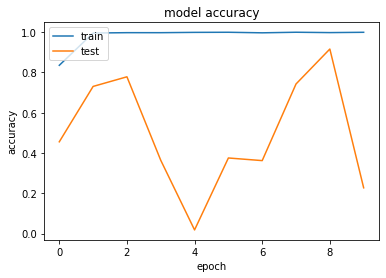

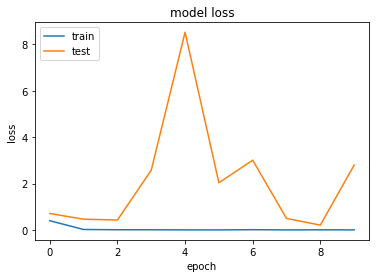

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred2={}
for i in range(3):
  pred2[i]=model.predict(test2xn[i])

In [ ]:
def acc_scor(act,pred):
  predic=np.zeros([11408,1])
  j=0
  for i in pred:
    predic[j,:]=str(np.argmax(i))
    j+=1
  predic=np.char.mod('%d', predic)
  return accuracy_score(act,predic)

In [ ]:
for i in range(3):
  print('test',i+1,":",acc_scor(test2yn[i],pred2[i]))

test 1 : 0.6601507713884993
test 2 : 0.40997545582047684
test 3 : 0.5298036465638148


In [ ]:
#tuning the model 
def model_tune():

  init_input=keras.Input(shape=(16,16,1),name="image")
  x1=layers.Conv2D(4,(4,4),strides=2)(init_input)
  x1=layers.MaxPooling2D((2,2))(x1)
  x3=layers.Conv2D(16,(3,3),strides=2,padding="same")(x1)
  x3=layers.BatchNormalization()(x3)
  x4=layers.Flatten()(x3)
  x4=layers.Activation("relu")(x4)
  x5=layers.Dense(64,"relu")(x4)
  x6=layers.Dropout(0.2)(x5)
  x7=layers.Dense(16,"relu")(x6)
  x8=layers.Dense(4)(x7)
  pred=layers.Activation("softmax")(x8)
  model=keras.Model(inputs=init_input,outputs=pred)
  model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
  return model

In [ ]:
model=model_tune()
history=model.fit(trainxshuf2,trainyshuf2,batch_size=64,validation_split=0.2,epochs=10)

Epoch 1/10
571/571 [==============================] - 3s 5ms/step - loss: 0.5367 - accuracy: 0.7699 - val_loss: 3.7497 - val_accuracy: 0.0000e+00
Epoch 2/10
571/571 [==============================] - 3s 5ms/step - loss: 0.2096 - accuracy: 0.9218 - val_loss: 4.0298 - val_accuracy: 0.0000e+00
Epoch 3/10
571/571 [==============================] - 3s 5ms/step - loss: 0.0339 - accuracy: 0.9918 - val_loss: 0.0459 - val_accuracy: 0.9977
Epoch 4/10
571/571 [==============================] - 3s 5ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 5/10
571/571 [==============================] - 3s 4ms/step - loss: 0.0086 - accuracy: 0.9980 - val_loss: 3.7338 - val_accuracy: 0.3610
Epoch 6/10
571/571 [==============================] - 3s 5ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 1.3094 - val_accuracy: 0.4257
Epoch 7/10
571/571 [==============================] - 3s 5ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 2.4712 - val_accuracy: 0.364

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


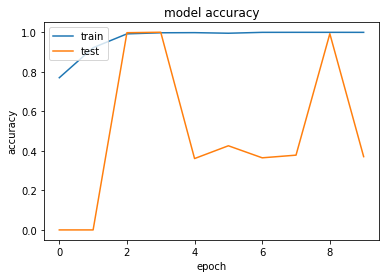

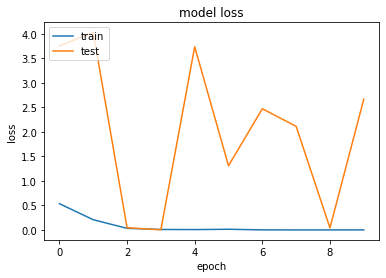

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred2={}
for i in range(3):
  pred2[i]=model.predict(test2xn[i])

In [ ]:
for i in range(3):
  print('test',i+1,":",acc_scor(test2yn[i],pred2[i]))

test 1 : 0.679523141654979
test 2 : 0.30487377279102384
test 3 : 0.7031907433380085
